# 範例 : (Kaggle)房價預測

# [教學目標]
- 以下用房價預測資料, 練習特徵重要性的寫作與觀察
- 由於只有樹狀模型有特徵重要性, 故以隨機森林為模型作為範例

# [範例重點]
- 使用擬合過的模型, 計算特徵重要性 (In[4], Out[4]) 
- 對照原始特徵, 觀察特徵重要性較高的一半特徵, 搭配隨機森林對於測結果的影響 (In[5], Out[5], In[6], Out[6])
- 重組重要性最高的特徵作為新特徵, 觀察效果如何 (In[9], Out[9]) 

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [1]:
# 請先確認您的 sklearn 版本是否相同, 如果版本不是 0.21.1 版, 有可能跑出與本範例不同的結果
import sklearn
sklearn.__version__

'0.21.2'

In [4]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

house_train_link = 'https://drive.google.com/open?id=1dMlOpTaNorcMgwLhC6wM2F8Gzq_U0kSQ'
fluff, house_train_id = house_train_link.split('=')
downloaded_house_train = drive.CreateFile({'id':house_train_id}) 
downloaded_house_train.GetContentFile('house_train.csv.gz')
df_house_train = pd.read_csv('house_train.csv.gz')

house_test_link = 'https://drive.google.com/open?id=1oaZLWkcN1A_wdhpp4rFkZYKgrPhfZyjz'
fluff, house_test_id = house_test_link.split('=')
downloaded_house_test = drive.CreateFile({'id':house_test_id}) 
downloaded_house_test.GetContentFile('house_test.csv.gz')
df_house_test = pd.read_csv('house_test.csv.gz')


train_Y = np.log1p(df_house_train['SalePrice'])
df = df_house_train.drop(['Id', 'SalePrice'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [5]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.235294,0.75,0.210191,0.033420,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.208333,0.250,0.285714,0.0,0.714286,0.666667,0.500,0.949275,0.883333,0.2,0.142857,0.857143,0.866667,0.50,0.123048,0.666667,1.0,0.4,0.75,1.0,1.00,0.500000,0.125089,1.0,0.0,0.064212,0.140098,0.2,0.0,1.0,1.0,0.119780,0.413559,0.0,0.259231,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.666667,0.500000,1.0,0.000000,0.0,0.333333,0.996519,0.666667,0.50,0.386460,1.0,1.0,1.0,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,1.0,0.8
1,0.000000,0.75,0.257962,0.038795,1.0,0.0,1.0,1.0,0.0,0.5,0.0,1.000000,0.125,0.285714,0.0,0.285714,0.555556,0.875,0.753623,0.433333,0.2,0.142857,0.571429,0.533333,0.75,0.000625,1.000000,1.0,0.2,0.75,1.0,0.50,0.166667,0.173281,1.0,0.0,0.121575,0.206547,0.2,0.0,1.0,1.0,0.212942,0.000000,0.0,0.174830,0.000000,0.5,0.666667,0.0,0.375,0.333333,1.000000,0.333333,1.0,0.333333,1.0,0.333333,0.983093,0.666667,0.50,0.324401,1.0,1.0,1.0,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.25,1.0,0.8
2,0.235294,0.75,0.219745,0.046507,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.208333,0.250,0.285714,0.0,0.714286,0.666667,0.500,0.934783,0.866667,0.2,0.142857,0.857143,0.866667,0.50,0.101811,0.666667,1.0,0.4,0.75,1.0,0.75,0.500000,0.086109,1.0,0.0,0.185788,0.150573,0.2,0.0,1.0,1.0,0.134465,0.419370,0.0,0.273549,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.666667,0.333333,1.0,0.333333,1.0,0.333333,0.995525,0.666667,0.50,0.428773,1.0,1.0,1.0,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.727273,0.50,1.0,0.8
3,0.294118,0.75,0.194268,0.038561,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.250000,0.250,0.285714,0.0,0.714286,0.666667,0.500,0.311594,0.333333,0.2,0.142857,0.928571,1.000000,0.75,0.000625,1.000000,1.0,0.0,1.00,0.5,1.00,0.166667,0.038271,1.0,0.0,0.231164,0.123732,0.2,0.5,1.0,1.0,0.143873,0.366102,0.0,0.260550,0.333333,0.0,0.333333,0.0,0.375,0.333333,0.666667,0.416667,1.0,0.333333,0.6,1.000000,0.994033,1.000000,0.75,0.452750,1.0,1.0,1.0,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.00,1.0,0.0
4,0.235294,0.75,0.270701,0.060576,1.0,0.0,0.0,1.0,0.0,0.5,0.0,0.625000,0.250,0.285714,0.0,0.714286,0.777778,0.500,0.927536,0.833333,0.2,0.142857,0.857143,0.866667,0.50,0.219238,0.666667,1.0,0.4,0.75,1.0,0.25,0.500000,0.116052,1.0,0.0,0.209760,0.187398,0.2,0.0,1.0,1.0,0.186095,0.509927,0.0,0.351168,0.333333,0.0,0.666667,0.5,0.500,0.333333,0.666667,0.583333,1.0,0.333333,1.0,0.333333,0.995027,0.666667,0.75,0.589563,1.0,1.0,1.0,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.50,1.0,0.8


In [6]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestRegressor()
estimator.fit(df.values, train_Y)
# estimator.feature_importances_ 就是模型的特徵重要性, 這邊先與欄位名稱結合起來, 才能看到重要性與欄位名稱的對照表
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


OverallQual      0.558828
GrLivArea        0.095643
GarageCars       0.045489
TotalBsmtSF      0.043501
1stFlrSF         0.030507
BsmtFinSF1       0.027165
GarageArea       0.022530
LotArea          0.014304
YearBuilt        0.011885
FullBath         0.009941
MSZoning         0.009738
CentralAir       0.009409
YearRemodAdd     0.009139
OverallCond      0.008828
2ndFlrSF         0.006863
GarageYrBlt      0.006475
BsmtUnfSF        0.005719
GarageType       0.004913
LotFrontage      0.004859
KitchenQual      0.004850
OpenPorchSF      0.004230
Fireplaces       0.003972
MoSold           0.003830
Neighborhood     0.003765
WoodDeckSF       0.002938
ExterCond        0.002852
KitchenAbvGr     0.002684
MasVnrArea       0.002677
SaleCondition    0.002547
Exterior1st      0.002539
                   ...   
MSSubClass       0.000891
LotConfig        0.000857
EnclosedPorch    0.000842
Fence            0.000692
ExterQual        0.000692
Heating          0.000683
Foundation       0.000652
ScreenPorch 

In [7]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8529645174751609

In [8]:
# 高重要性特徵 + 隨機森林 (39大約是79的一半)
high_feature = list(feats[:39].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.861237818880668

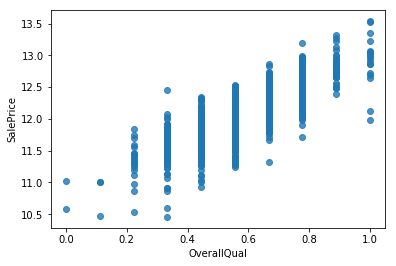

In [9]:
# 觀察重要特徵與目標的分布
# 第一名 : OverallQual              
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=df['OverallQual'], y=train_Y, fit_reg=False)
plt.show()

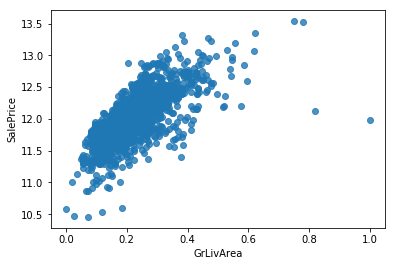

In [10]:
# 第二名 : GrLivArea
sns.regplot(x=df['GrLivArea'], y=train_Y, fit_reg=False)
plt.show()

In [11]:
# 製作四特徵 : 加, 乘, 互除(分母加1避免除0) 看效果 (Note: 數值原本已經最大最小化介於 [0,1] 區間, 這四種新特徵也會落在 [0,1] 區間)
df['Add_char'] = (df['GrLivArea'] + df['OverallQual']) / 2
df['Multi_char'] = df['GrLivArea'] * df['OverallQual']
df['GO_div1p'] = df['GrLivArea'] / (df['OverallQual']+1) * 2
df['OG_div1p'] = df['OverallQual'] / (df['GrLivArea']+1) * 2
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8608966765317705

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?